# Decision Trees and Random Forests

We will need the following libraries:

In [1]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import graphviz
import random
import os

import warnings
warnings.filterwarnings('ignore')

print('The graphviz version is {}.'.format(graphviz.__version__))

The graphviz version is 0.20.


Set some variable

In [2]:
BNAB="gp120_CD4BS"  # The 5 bnab types are:  gp120_CD4BS     gp120_V2      gp120_V3     gp41_MPER     gp41-gp120_interface
CRITERION="entropy" 
RFMAXSAMPLES=1.0 
RFMAXDEPTH=None 
SEEDNUMBER=1 

#here we set the experience of pooled HIV-1 immune donors  to process
EXP="G4"
EXPPATH="HIVdonors_AIRR/"+EXP+"/"

#for the graph
plt.rcParams['font.family'] = 'Arial'


# Exploration

In [3]:
%matplotlib inline

Let us have a look at the dataset:

In [4]:
DATAPATH="input_data/"
if not os.path.exists("output/"):
    os.mkdir("output/")
OUTPUTPATH="output/"+BNAB+"/"
if not os.path.exists(OUTPUTPATH):
    os.mkdir(OUTPUTPATH)

In [5]:
data=pd.read_csv(DATAPATH+"features_table_"+BNAB+".tsv",sep='\t')
data.head(3)

,vh.gene,HCDR3.length,hcdr3.hydrophobicity,vl.gene,LCDR3.length,mut.freq,fwrs.mut.freq,VH1.lcdr3_5,VH1-69.VK3-20.GW,is.bnAb
0,IGHV3-66,20,3.90,IGKV1-5,9,0.01,0.01,0,0,0
1,IGHV4-59,12,1.45,IGKV4-1,9,0.08,0.07,0,0,0
2,IGHV6-1,7,0.95,IGKV4-1,9,0.00,0.00,0,0,0


Let us convert the categorical labels in "vh.gene" and "vl.gene" in one-hot encoding:

In [6]:
df1=data[["HCDR3.length","mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","LCDR3.length","VH1.lcdr3_5","VH1-69.VK3-20.GW","is.bnAb"]] 
df2=pd.get_dummies(data["vh.gene"])
df3=pd.get_dummies(data["vl.gene"])

In [7]:
frames=[df1,df2,df3]
df=pd.concat(frames,axis=1)

In [8]:
df.head()

,HCDR3.length,mut.freq,fwrs.mut.freq,hcdr3.hydrophobicity,LCDR3.length,VH1.lcdr3_5,VH1-69.VK3-20.GW,is.bnAb,IGHV1-18,IGHV1-2,...,IGLV4-69,IGLV5-37,IGLV5-39,IGLV5-45,IGLV5-48,IGLV6-57,IGLV7-43,IGLV7-46,IGLV8-61,IGLV9-49
0,20,0.01,0.01,3.90,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12,0.08,0.07,1.45,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0.00,0.00,0.95,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20,0.18,0.15,2.10,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,0.01,0.01,3.60,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(15016, 123)

There are 15'016 data points with 122 input features (116 columns are one-hot encoding columns associated to "vh.gene" and "vl.gene") and 1 output feature

In [10]:
df.describe()

,HCDR3.length,mut.freq,fwrs.mut.freq,hcdr3.hydrophobicity,LCDR3.length,VH1.lcdr3_5,VH1-69.VK3-20.GW,is.bnAb,IGHV1-18,IGHV1-2,...,IGLV4-69,IGLV5-37,IGLV5-39,IGLV5-45,IGLV5-48,IGLV6-57,IGLV7-43,IGLV7-46,IGLV8-61,IGLV9-49
count,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.0,15016.000000,15016.000000,15016.000000,...,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000
mean,15.526705,0.073363,0.058054,2.616353,9.672416,0.001931,0.0,0.003596,0.034030,0.038292,...,0.010722,0.000466,0.000133,0.002397,0.000200,0.008458,0.005527,0.007991,0.010456,0.001532
std,3.778669,0.064633,0.057520,1.317874,1.139068,0.043905,0.0,0.059862,0.181313,0.191908,...,0.102993,0.021587,0.011540,0.048907,0.014134,0.091579,0.074143,0.089040,0.101720,0.039108
min,4.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,0.000000,0.000000,1.650000,9.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.000000,0.070000,0.050000,2.450000,9.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,0.120000,0.090000,3.400000,10.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,33.000000,0.510000,0.540000,8.950000,22.000000,1.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
dff=df1
dff["is.bnAb"]=data["is.bnAb"].astype('category')
dff.groupby("is.bnAb").size()

is.bnAb
0    14962
1       54
dtype: int64

The dataset is highly imbalanced. We will need to use weights in the models to make the "rare" class comparable to the normal class. 

Let us look at the pair plots:

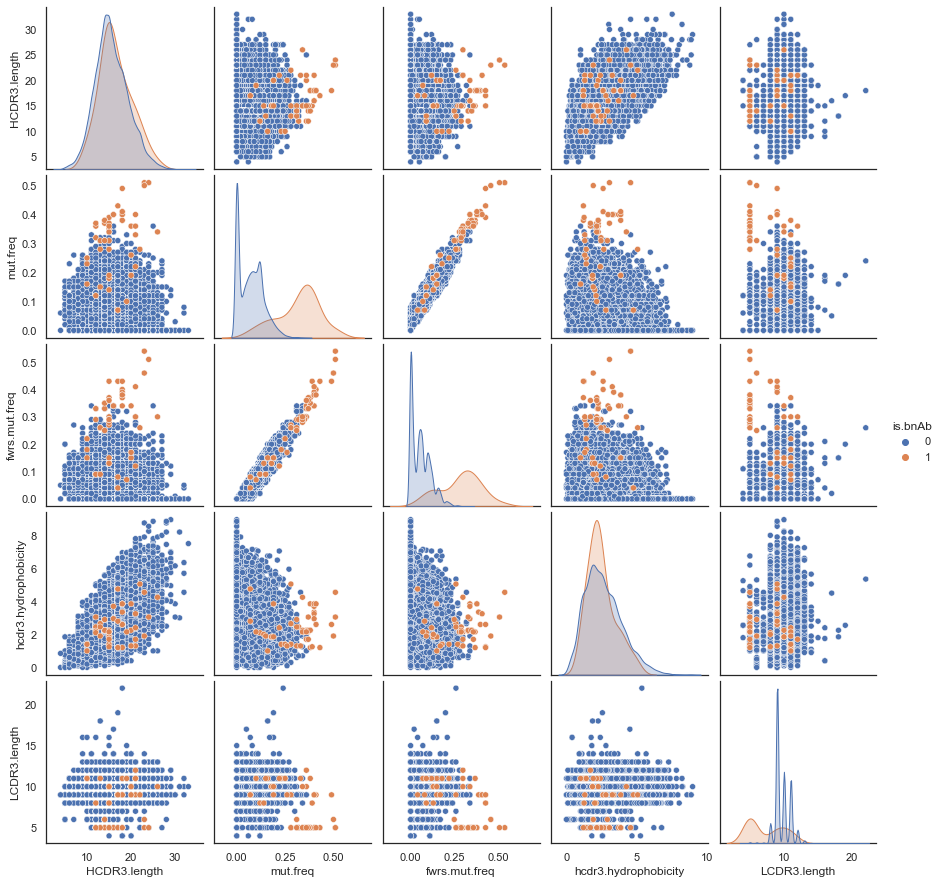

In [12]:
dff_for_pair_plot=dff[["HCDR3.length","mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","LCDR3.length","is.bnAb"]]
colors = ["darksalmon", "lightsteelblue"]
customPalette = sns.set_palette(sns.color_palette(colors))
#sns.pairplot(dff_for_pair_plot,hue='is.bnAb',palette=customPalette)
sns.set(font_scale=1.2)
sns.set_theme(style='white')
fig =sns.pairplot(dff_for_pair_plot,hue='is.bnAb',palette=customPalette,diag_kws=dict(common_norm=False))
fig.savefig(OUTPUTPATH+'pairplot_'+BNAB+'.pdf', bbox_inches='tight')

In [13]:
fig.savefig(OUTPUTPATH+'pairplot_'+BNAB+'.png', bbox_inches='tight',dpi=300)

We see that the rare class (red dots) are not easily separated from the normal class (blue dots). More precisely, several red dots are clearly separated from the blue cluster, but some red dots are located inside the blue cluster.

### Split the input table into TRAIN, VALIDATION and TEST sets

In [14]:
seed=SEEDNUMBER
np.random.seed(seed)
random.seed(seed)
random_state=seed

training,test,trainingtarget,testtarget=train_test_split(df.loc[:,df.columns != "is.bnAb"],df.loc[:,"is.bnAb"],
                                                         test_size=0.2,random_state=random_state)
training,validation,trainingtarget,validationtarget=train_test_split(training,trainingtarget,
                                                                     test_size=0.25,random_state=random_state) # 0.25 x 0.8 = 0.2



# Decision tree

We are now going to build a decision tree to predict is.bnAb (0 or 1) for any given data point (represented by the input features). 

In [15]:
tree=DecisionTreeClassifier(criterion=CRITERION,class_weight="balanced",random_state=random_state)
tree=tree.fit(training,trainingtarget)

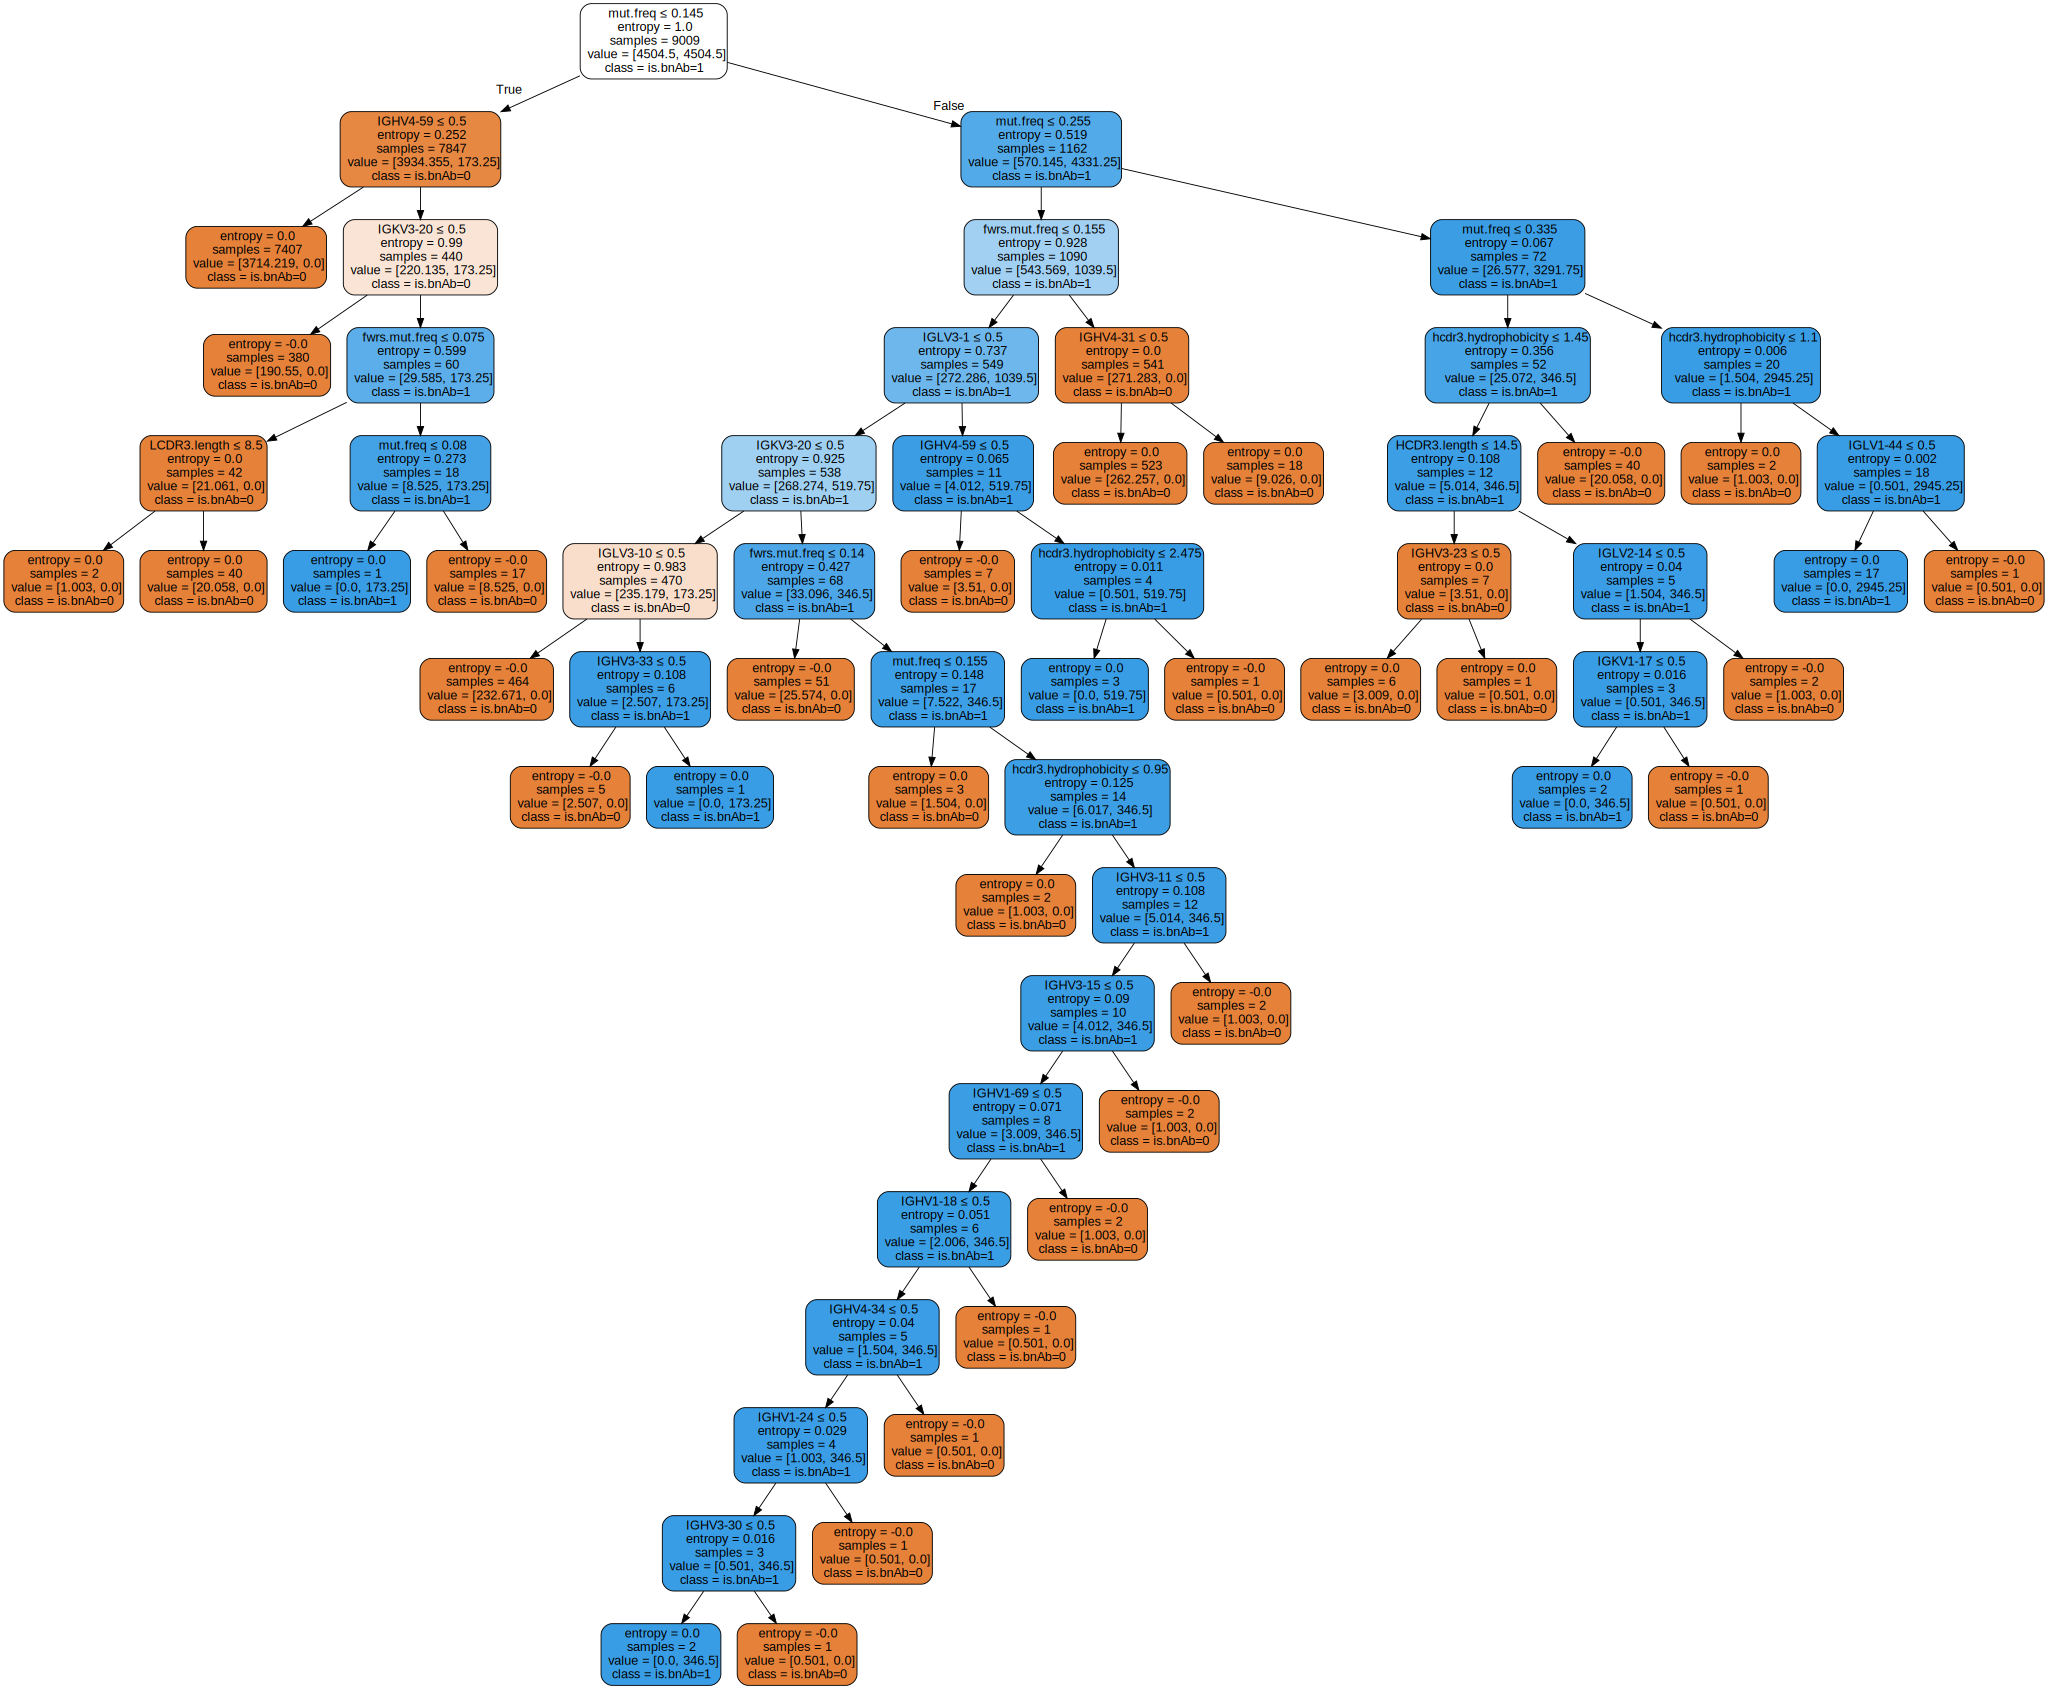

In [16]:
dot_data=export_graphviz(tree,out_file=None,feature_names=list(training),class_names=["is.bnAb=0","is.bnAb=1"],
                         filled=True,rounded=True,special_characters=True)  
graph=graphviz.Source(dot_data, format="pdf") 
graph 

This is the biggest tree possible. We now need to prune this tree up to the smallest validation error (or highest validation accuracy). Let us first find the values of the cost complexity pruning parameter alpha (ccp_alpha):

In [17]:
path=tree.cost_complexity_pruning_path(training,trainingtarget)
ccp_alphas=path.ccp_alphas

We remove the last element in ccp_alphas because it corresponds to the trivial tree with only one node: 

In [18]:
ccp_alphas=ccp_alphas[:-1]

Let us look at the alpha values:

In [19]:
ccp_alphas

array([0.00000000e+00, 3.36996332e-18, 8.76190462e-17, 9.84886935e-15,
       4.94233807e-04, 6.05381296e-04, 6.37921361e-04, 7.25191146e-04,
       7.77180373e-04, 9.46450221e-04, 9.53225015e-04, 1.28974142e-03,
       2.10500335e-03, 2.65817518e-03, 3.13175591e-03, 5.50962288e-03,
       7.98526591e-03, 9.25315812e-03, 1.21610989e-02, 2.78063250e-02,
       2.97224308e-02, 5.57834847e-02, 7.17673568e-02, 9.43483353e-02])

We loop over the subtrees associated to these alpha values:

In [20]:
subtrees=[]
for ccp_alpha in ccp_alphas:
    subtree=DecisionTreeClassifier(criterion=CRITERION,class_weight="balanced",ccp_alpha=ccp_alpha,random_state=random_state)
    subtree.fit(training,trainingtarget)
    subtrees.append(subtree)

To choose the "best" tree (i.e. the best value for alpha), let us look at various performance metrics:

In [21]:
depths=[subtree.tree_.max_depth for subtree in subtrees]

validation_accuracies=[]
validation_aucs=[]
validation_TPRs=[]
validation_TNRs=[]
validation_FPRs=[]
validation_PPVs=[]
validation_TPs=[]
validation_FPs=[]
validation_Ratios=[]
for subtree in subtrees:
    validation_accuracy=subtree.score(validation,validationtarget)
    validation_accuracies.append(validation_accuracy)
    
    prediction_probabilities=subtree.predict_proba(validation)[:,1]
    AUC=roc_auc_score(validationtarget,prediction_probabilities)
    validation_aucs.append(AUC)
    
    predictions_validation=subtree.predict(validation)
    cm=confusion_matrix(validationtarget,predictions_validation)
    
    TN=cm[0,0]
    FP=cm[0,1]
    FN=cm[1,0]
    TP=cm[1,1]
    
    validation_TPs.append(TP)
    validation_FPs.append(FP)
    
    # Sensitivity, recall, or true positive rate
    # (the ability of the classifier to find all the positive samples)
    TPR=TP/(TP+FN) 
    validation_TPRs.append(TPR)
    
    # Specificity or true negative rate
    TNR=TN/(TN+FP) 
    validation_TNRs.append(TNR)
    
    # Fall out or false positive rate
    FPR=FP/(FP+TN)
    validation_FPRs.append(FPR)
    
    # Precision or positive predictive value 
    # (the ability of the classifier not to label a negative sample as positive)
    PPV=TP/(TP+FP) 
    validation_PPVs.append(PPV)
    
    # The ratio to maximize
    epsilon=0.0001
    Ratio=TP/(FP+epsilon)
    validation_Ratios.append(Ratio)

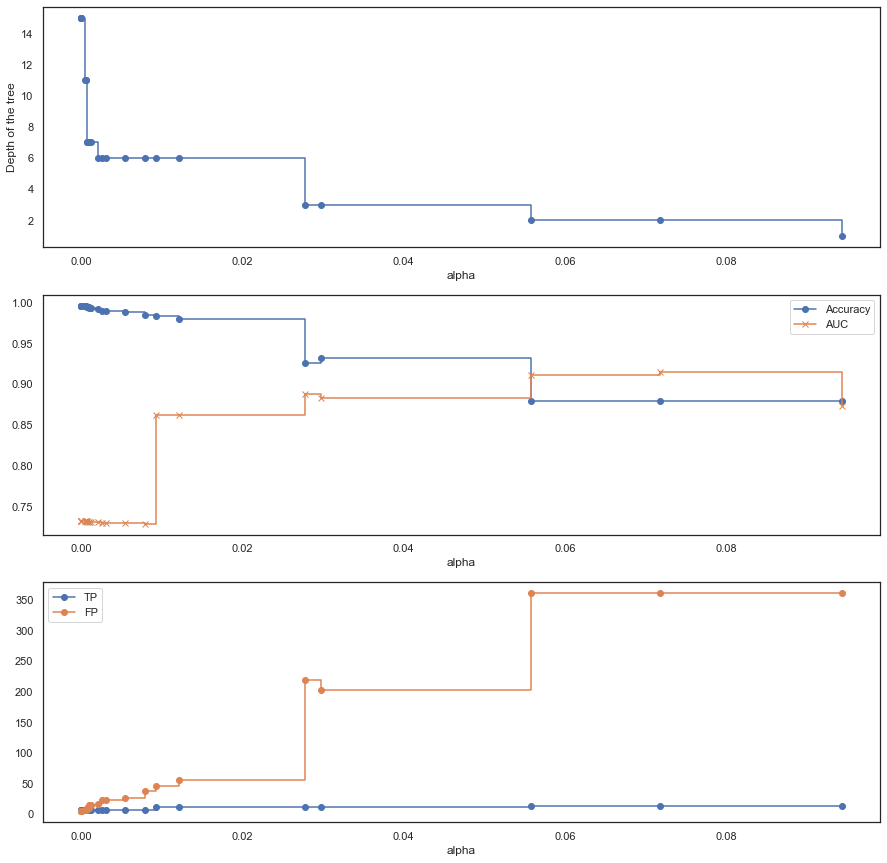

In [22]:
fig,ax=plt.subplots(3,1,figsize=(15, 15))

ax[0].plot(ccp_alphas,depths,marker='o',drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("Depth of the tree")

line1, =ax[1].plot(ccp_alphas,validation_accuracies,marker='o',drawstyle="steps-post",label='Accuracy')
line2, = ax[1].plot(ccp_alphas,validation_aucs,marker='x',drawstyle="steps-post",label='AUC')
ax[1].set_xlabel("alpha")
ax[1].legend(handles=[line1, line2])


#line1, =ax[2].plot(ccp_alphas,validation_FPRs,marker='o',drawstyle="steps-post",label='FPR')
#line2, =ax[2].plot(ccp_alphas,validation_PPVs,marker='o',drawstyle="steps-post",label='PPV')
#ax[2].set_xlabel("alpha")
#ax[2].legend(handles=[line1, line2])

line1, =ax[2].plot(ccp_alphas,validation_TPs,marker='o',drawstyle="steps-post",label='TP')
line2, =ax[2].plot(ccp_alphas,validation_FPs,marker='o',drawstyle="steps-post",label='FP')
ax[2].set_xlabel("alpha")
ax[2].legend(handles=[line1, line2])

#line1, =ax[4].plot(ccp_alphas,validation_Ratios,marker='o',drawstyle="steps-post",label='TP/FP')
#ax[4].set_xlabel("alpha")
#ax[4].legend(handles=[line1])

#plt.show()
plt.savefig(OUTPUTPATH+'prunedTree_AUC_TP_FP_plots_'+BNAB+'_seed'+str(SEEDNUMBER)+'.svg', bbox_inches='tight')


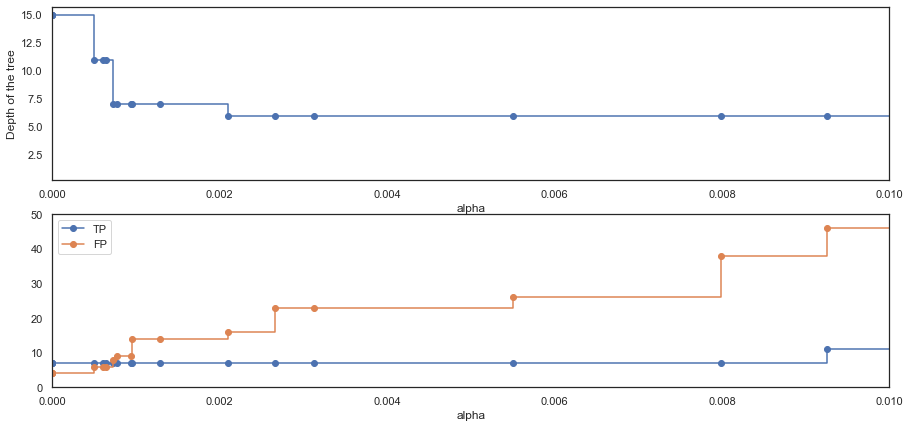

In [23]:
fig,ax=plt.subplots(2,1,figsize=(15, 7))

ax[0].plot(ccp_alphas,depths,marker='o',drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_xlim(0,0.01)
ax[0].set_ylabel("Depth of the tree")

line1, =ax[1].plot(ccp_alphas,validation_TPs,marker='o',drawstyle="steps-post",label='TP')
line2, =ax[1].plot(ccp_alphas,validation_FPs,marker='o',drawstyle="steps-post",label='FP')
ax[1].set_xlabel("alpha")
ax[1].set_xlim(0,0.01)
ax[1].set_ylim(0,50)
ax[1].legend(handles=[line1, line2])

plt.show()

We want a small FPR and a large PPV. This is obtained by taking a small alpha value. As alpha decreaes the accuracy increases, which is good, but the AUC decreases. The smallest alpha is alpha=0, which corresponds to the biggest possible tree. This is the value we should take if we want to limit the number of FPs.

In [24]:
tree_pruned=DecisionTreeClassifier(criterion=CRITERION,class_weight="balanced",ccp_alpha=0,random_state=random_state)
tree_pruned=tree_pruned.fit(training,trainingtarget)

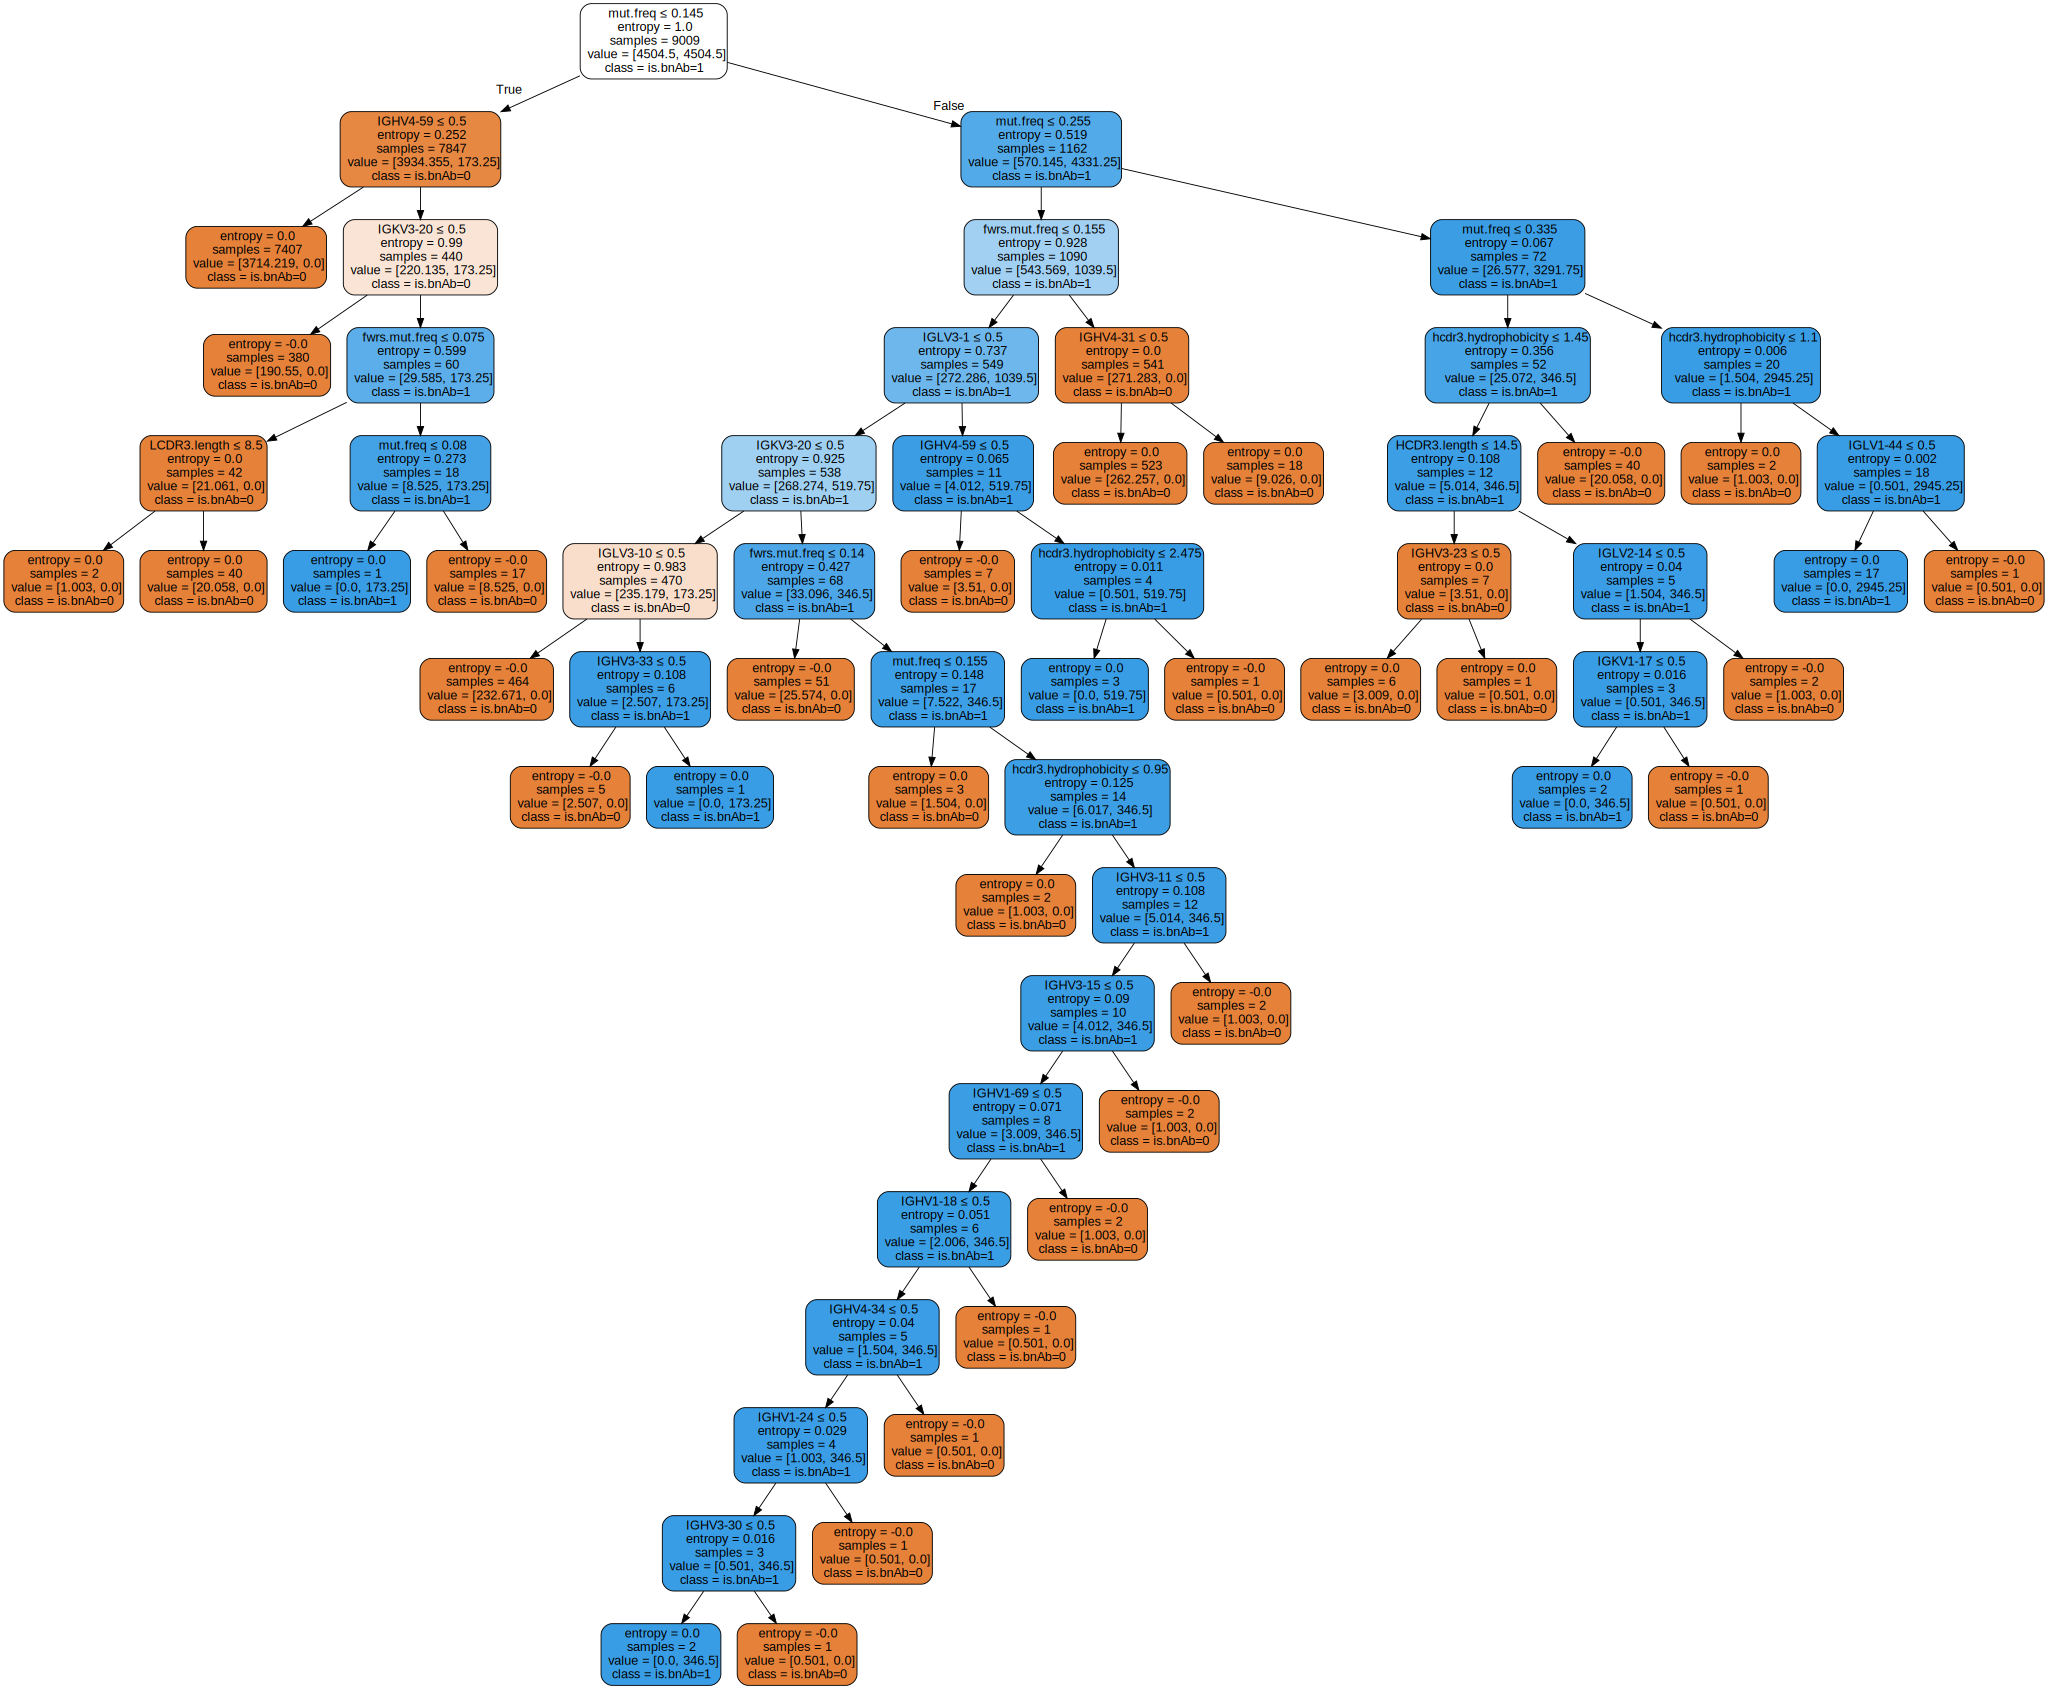

In [25]:
dot_data=export_graphviz(tree_pruned,out_file=None,feature_names=list(training),class_names=["is.bnAb=0","is.bnAb=1"],
                         filled=True,rounded=True,special_characters=True)  
graph=graphviz.Source(dot_data, format="pdf") 
graph 

In [26]:
graph.render(OUTPUTPATH+"pruned_tree_"+BNAB+"_seed"+str(SEEDNUMBER))

'output/gp120_CD4BS/pruned_tree_gp120_CD4BS_seed1.pdf'

Predict the output classes with the pruned tree for the training dataset:

In [27]:
predictions_training=tree_pruned.predict(training)
confusion_matrix(trainingtarget,predictions_training)

array([[8983,    0],
       [   0,   26]])

Predict the output classes with the pruned tree for the validation dataset:

In [28]:
predictions_validation=tree_pruned.predict(validation)
cm=confusion_matrix(validationtarget,predictions_validation)
print(cm)
tn_v_tree, fp_v_tree, fn_v_tree, tp_v_tree = cm.ravel()


[[2984    4]
 [   8    7]]


Write the validation TP and FP in text file for comparison with 2 ML methods

In [29]:
#Make a big table with predicted and known bnab
# Save TP and FP in txt files to compare them with the 2 other methods
valTable= validation.copy()
valTable['is_bnab']= validationtarget
valTable['predicted'] = predictions_validation
dataf=valTable[(valTable['predicted'] == 1) & (valTable['is_bnab'] == 0)]
print(dataf)
dataf.to_csv(OUTPUTPATH+'validation_FP_prunedTree_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")
dataf=valTable[(valTable['predicted'] == 1) & (valTable['is_bnab'] == 1)]
print(dataf)
dataf.to_csv(OUTPUTPATH+'validation_TP_prunedTree_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")



       HCDR3.length  mut.freq  fwrs.mut.freq  hcdr3.hydrophobicity  \
7573             14      0.16           0.15                  2.75   
14800            12      0.08           0.09                  2.45   
477              15      0.34           0.34                  1.90   
12841            16      0.36           0.30                  1.85   

       LCDR3.length  VH1.lcdr3_5  VH1-69.VK3-20.GW  IGHV1-18  IGHV1-2  \
7573              8            0                 0         0        0   
14800             9            0                 0         0        0   
477               8            0                 0         0        0   
12841             9            0                 0         1        0   

       IGHV1-24  ...  IGLV5-39  IGLV5-45  IGLV5-48  IGLV6-57  IGLV7-43  \
7573          0  ...         0         0         0         0         0   
14800         0  ...         0         0         0         0         0   
477           0  ...         0         0         0         0 

Comparing this result with the training one, we that there is some overfitting. This was expected because we used the largest possible tree.

In [30]:
predictions=pd.DataFrame(predictions_validation,columns=["prediction"])
predictions.index=validation.index
frames=[validation,validationtarget,predictions]
results_validation=pd.concat(frames,axis=1)

In [31]:
results_validation.head()

,HCDR3.length,mut.freq,fwrs.mut.freq,hcdr3.hydrophobicity,LCDR3.length,VH1.lcdr3_5,VH1-69.VK3-20.GW,IGHV1-18,IGHV1-2,IGHV1-24,...,IGLV5-39,IGLV5-45,IGLV5-48,IGLV6-57,IGLV7-43,IGLV7-46,IGLV8-61,IGLV9-49,is.bnAb,prediction
14181,15,0.11,0.10,2.65,9,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8902,19,0.09,0.06,3.90,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12694,14,0.14,0.11,2.75,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6501,15,0.09,0.07,2.55,11,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8849,21,0.04,0.04,3.35,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
results_validation[results_validation["prediction"]==1]

,HCDR3.length,mut.freq,fwrs.mut.freq,hcdr3.hydrophobicity,LCDR3.length,VH1.lcdr3_5,VH1-69.VK3-20.GW,IGHV1-18,IGHV1-2,IGHV1-24,...,IGLV5-39,IGLV5-45,IGLV5-48,IGLV6-57,IGLV7-43,IGLV7-46,IGLV8-61,IGLV9-49,is.bnAb,prediction
14977,15,0.39,0.43,1.25,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
14962,15,0.31,0.29,1.30,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
7573,14,0.16,0.15,2.75,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14995,23,0.51,0.54,4.55,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
15014,15,0.36,0.36,2.15,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
14800,12,0.08,0.09,2.45,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
477,15,0.34,0.34,1.90,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12841,16,0.36,0.30,1.85,9,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
14970,18,0.41,0.40,2.60,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
15000,14,0.38,0.35,2.25,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1


In [33]:
scores=tree_pruned.score(validation,validationtarget)
print("Validation accuracy rate:: %.2f%%"%(scores*100))
print("Validation error rate: %.2f%%"%(100-scores*100))

Validation accuracy rate:: 99.60%
Validation error rate: 0.40%


In [34]:
predictions=tree_pruned.predict_proba(validation)[:,1]
fpr,tpr,thresholds=roc_curve(validationtarget,predictions)
AUC=roc_auc_score(validationtarget,predictions)
AUC_v_tree=AUC

Test dataset with pruned_tree

In [35]:
predictions=tree_pruned.predict(test)
cm=confusion_matrix(testtarget,predictions)
print(cm)
tn_t_tree, fp_t_tree, fn_t_tree, tp_t_tree = cm.ravel()

[[2985    6]
 [   4    9]]


In [36]:
fpr,tpr,thresholds=roc_curve(testtarget,predictions)
AUC=roc_auc_score(testtarget,predictions)
AUC_t_tree=AUC

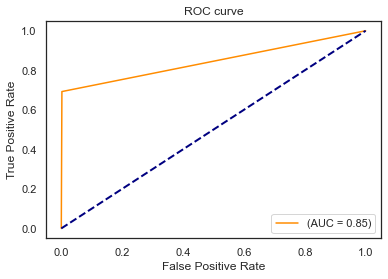

In [37]:
plt.plot(fpr,tpr,color="darkorange",label="(AUC = %0.2f)"%AUC)
plt.plot([0, 1],[0, 1],color="navy",lw=2,linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title('ROC curve')
#plt.show()

plt.savefig(OUTPUTPATH+'prunedTree_ROCcurve_'+BNAB+'_seed'+str(SEEDNUMBER)+'.pdf', bbox_inches='tight')


In [38]:
#Make a big table with predicted and known bnab
# Save TP and FP in txt files to compare them with the 2 other methods
testTable= test.copy()
testTable['is_bnab']= testtarget
testTable['predicted'] = predictions
dataf=testTable[(testTable['predicted'] == 1) & (testTable['is_bnab'] == 0)]
print(dataf)
dataf.to_csv(OUTPUTPATH+'test_FP_prunedTree_'+BNAB+'_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")
dataf=testTable[(testTable['predicted'] == 1) & (testTable['is_bnab'] == 1)]
print(dataf)
dataf.to_csv(OUTPUTPATH+'test_TP_prunedTree_'+BNAB+'_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")

       HCDR3.length  mut.freq  fwrs.mut.freq  hcdr3.hydrophobicity  \
1296             21      0.18           0.15                  4.35   
4581             22      0.16           0.15                  6.75   
14907            15      0.30           0.28                  1.00   
11426            13      0.18           0.15                  3.10   
2887             13      0.18           0.15                  1.35   
12597            15      0.32           0.30                  0.70   

       LCDR3.length  VH1.lcdr3_5  VH1-69.VK3-20.GW  IGHV1-18  IGHV1-2  \
1296             11            0                 0         0        0   
4581              5            0                 0         0        0   
14907            12            0                 0         0        0   
11426             9            0                 0         0        0   
2887              6            0                 0         0        0   
12597             9            0                 0         0        0  

# Random forest

We are going to build a random forest to make prediction.

Build the random forest model using the entropy/gini index, 200 trees, sample of the same size of the training set with replacement, m=sqrt(122)=11 input variables for each question (or split) of the tree:

In [39]:
print(RFMAXDEPTH)
random_forest=RandomForestClassifier(criterion=CRITERION,class_weight="balanced",n_estimators=200,bootstrap=True,max_samples=RFMAXSAMPLES,max_features=11,max_depth=RFMAXDEPTH,random_state=random_state)
random_forest=random_forest.fit(training,trainingtarget)

None


Here the random_state variable controls the internal random generator that is used by the random forest algorithm (for example for selecting data points from the training dataset to make the M bootstrap training subsets or for selecting m=11 features from all the input features while building the M trees).

The validation AUC of the final random forest:

In [40]:
predictions=random_forest.predict_proba(validation)[:,1]
AUC=roc_auc_score(validationtarget,predictions)
print("Validation AUC =",AUC)

Validation AUC = 0.8949799196787148


Let us plot the validation AUC as a function of the number of trees used in the random forest:

In [41]:
aucs=[]
validation_TPs=[]
validation_FPs=[]
validation_Ratios=[]
for n in range(1,200):
    random_forest.set_params(n_estimators=n)
    random_forest.fit(training,trainingtarget)
    predictions=random_forest.predict_proba(validation)[:,1]
    AUC=roc_auc_score(validationtarget,predictions)
    aucs.append(AUC)
    
    predictions_validation=random_forest.predict(validation)
    cm=confusion_matrix(validationtarget,predictions_validation)
    
    TN=cm[0,0]
    FP=cm[0,1]
    FN=cm[1,0]
    TP=cm[1,1]
    
    validation_TPs.append(TP)
    validation_FPs.append(FP)
    
    epsilon=0.0001
    Ratio=TP/(FP+epsilon)
    validation_Ratios.append(Ratio)

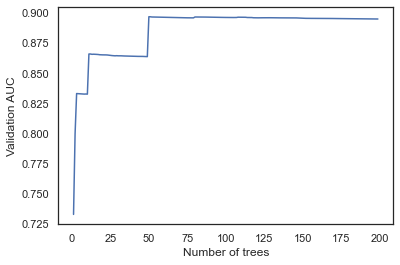

In [42]:
x=range(1,200)
y=aucs

plt.plot(x, y)
plt.xlabel("Number of trees")
plt.ylabel("Validation AUC")
#plt.show()
plt.savefig(OUTPUTPATH+'RF_trees_number_'+BNAB+'_seed'+str(SEEDNUMBER)+'.pdf', bbox_inches='tight')

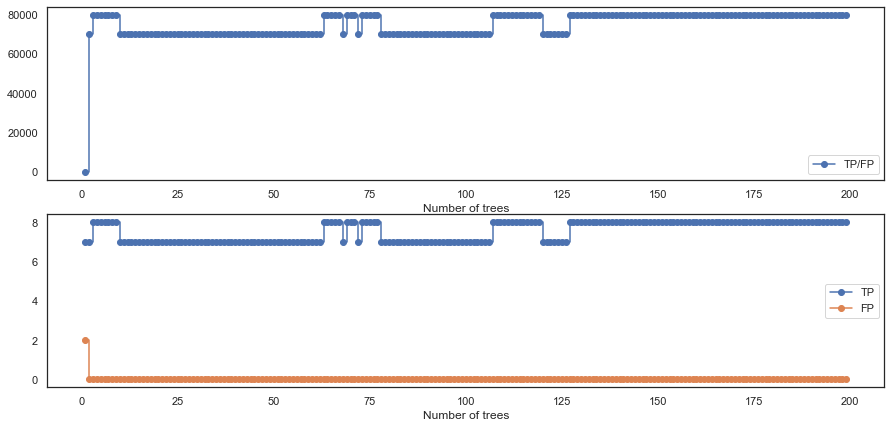

In [43]:
fig,ax=plt.subplots(2,1,figsize=(15, 7))

line1, =ax[0].plot(x,validation_Ratios,marker='o',drawstyle="steps-post",label='TP/FP')
ax[0].set_xlabel("Number of trees")
ax[0].legend(handles=[line1])

line1, =ax[1].plot(x,validation_TPs,marker='o',drawstyle="steps-post",label='TP')
line2, =ax[1].plot(x,validation_FPs,marker='o',drawstyle="steps-post",label='FP')
ax[1].set_xlabel("Number of trees")
ax[1].legend(handles=[line1, line2])

plt.show()

The x-axis is the "number of trees" and the y-axis is the "validation AUC". We see that we should use about 100 trees:

In [44]:
TREES_NUMBER=100
random_forest=RandomForestClassifier(criterion=CRITERION,class_weight="balanced",n_estimators=TREES_NUMBER,bootstrap=True,max_samples=RFMAXSAMPLES,max_features=11,max_depth=RFMAXDEPTH,random_state=random_state)
random_forest=random_forest.fit(training,trainingtarget)

Predict the output classes for the training dataset with the random forest model:

In [45]:
predictions=random_forest.predict(training)
confusion_matrix(trainingtarget,predictions)

array([[8983,    0],
       [   0,   26]])

This confusion matrix shows that the random forest has made some mistakes in the preditions.

The corresponding training accuracy:

In [46]:
scores=random_forest.score(training,trainingtarget)
print("Training accuracy rate:: %.2f%%"%(scores*100))
print("Training error rate: %.2f%%"%(100-scores*100))

Training accuracy rate:: 100.00%
Training error rate: 0.00%


We obtain almost 100% accuracy: the random forest has almost perfecly learned the training data. 

Predict the output classes for the validation dataset:

In [47]:
predictions=random_forest.predict(validation)
cm=confusion_matrix(validationtarget,predictions)
print(cm)
tn_v_RF, fp_v_RF, fn_v_RF, tp_v_RF = cm.ravel()

[[2988    0]
 [   8    7]]


This confusion matrix shows that the random forest has made some mistake in the preditions. The rare class is not well predicted.

Finally the validation accuracy:

In [48]:
scores=random_forest.score(validation,validationtarget)
print("Validation accuracy rate:: %.2f%%"%(scores*100))
print("Validation error rate: %.2f%%"%(100-scores*100))

Validation accuracy rate:: 99.73%
Validation error rate: 0.27%


The validation AUC:

In [49]:
predictions=random_forest.predict_proba(validation)[:,1]
AUC=roc_auc_score(validationtarget,predictions)
AUC_v_RF=AUC
print("Validation AUC =",AUC)

Validation AUC = 0.8962739848282016


In [50]:
#Make a big table with predicted and known bnab
# Save TP and FP in txt files to compare them with the 2 other methods
predictions=random_forest.predict(validation)
valTable= validation.copy()
valTable['is_bnab']= validationtarget
valTable['predicted'] = predictions
dataf=valTable[(valTable['predicted'] == 1) & (valTable['is_bnab'] == 0)]
#print(dataf)
dataf.to_csv(OUTPUTPATH+'validation_FP_randomForest_'+BNAB+'_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")
dataf=valTable[(valTable['predicted'] == 1) & (valTable['is_bnab'] == 1)]
#print(dataf)
dataf.to_csv(OUTPUTPATH+'validation_TP_randomForest_'+BNAB+'_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")
dataf.head()

,HCDR3.length,mut.freq,fwrs.mut.freq,hcdr3.hydrophobicity,LCDR3.length,VH1.lcdr3_5,VH1-69.VK3-20.GW,IGHV1-18,IGHV1-2,IGHV1-24,...,IGLV5-39,IGLV5-45,IGLV5-48,IGLV6-57,IGLV7-43,IGLV7-46,IGLV8-61,IGLV9-49,is_bnab,predicted
14962,15,0.31,0.29,1.30,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
14995,23,0.51,0.54,4.55,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
15014,15,0.36,0.36,2.15,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
14970,18,0.41,0.40,2.60,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
15000,14,0.38,0.35,2.25,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1


Compute and plot the importance (of all the variables):

In [51]:
feature_importance=pd.Series(random_forest.feature_importances_,index=list(test)).sort_values(ascending=False)
feature_importance

mut.freq            0.256735
fwrs.mut.freq       0.209804
LCDR3.length        0.095554
VH1.lcdr3_5         0.072990
HCDR3.length        0.067631
                      ...   
IGLV3-12            0.000000
IGHV4-28            0.000000
IGHV4/OR15-8        0.000000
VH1-69.VK3-20.GW    0.000000
IGKV1D-13           0.000000
Length: 122, dtype: float64

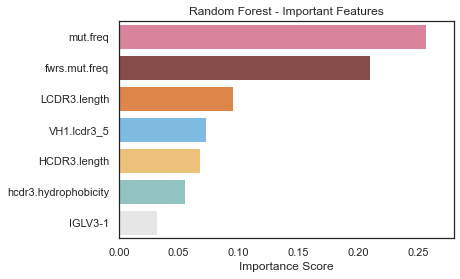

In [52]:
fig, ax = plt.subplots()
sns.barplot(x=feature_importance[:7],y=feature_importance.index[:7],color=feature_importance.index[:7],palette={"mut.freq":"#e87496","fwrs.mut.freq":"#8F433E",
    "hcdr3.hydrophobicity":"#88ccc9","HCDR3.length":"#ffc768","LCDR3.length":"#f58231","VH1.lcdr3_5":"#6fbdf0","IGHV1-18":"#DBDBDB","IGHV3-30":"#C2C2C2","IGHV3-15":"#A8A8A8",
    "IGHV1-69":"#8F8F8F","IGHV5-51":"#757575","IGHV1-2":"#5C5C5C","IGLV3-1":"#E6E6E6","IGKV1-39":"#CDCDCD"})
plt.xlabel('Importance Score')
plt.title("Random Forest - Important Features")
ax.set_xlim(0, 0.28)
plt.savefig(OUTPUTPATH+'RF_ImportantFeature_'+BNAB+'_seed'+str(SEEDNUMBER)+'.svg', bbox_inches='tight')
#plt.show()

We see that the  are the two most important predictors are "mut.freq" and "fwrs.mut.freq". To understand this results, you may want to look back at the previous decision tree and plots.

# Best model RF

Once you have found the best model (the one with the highest validation accuracy or the one with the fewest errors in the rare class), you may apply it to the test dataset. In the present situation, let us consider the random forest:

In [53]:
predictions=random_forest.predict(test)
cm=confusion_matrix(testtarget,predictions)
print(cm)
tn_t_RF, fp_t_RF, fn_t_RF, tp_t_RF = cm.ravel()
print(tp_t_RF)

[[2991    0]
 [   5    8]]
8


Finally the test accuracy:

In [54]:
scores=random_forest.score(test,testtarget)
print("Test accuracy rate:: %.2f%%"%(scores*100))
print("Test error rate: %.2f%%"%(100-scores*100))

Test accuracy rate:: 99.83%
Test error rate: 0.17%


The ROC curve and AUC value:

In [55]:
predictions=random_forest.predict_proba(test)[:,1]

fpr,tpr,thresholds=roc_curve(testtarget,predictions)

AUC=roc_auc_score(testtarget,predictions)
AUC_t_RF = AUC

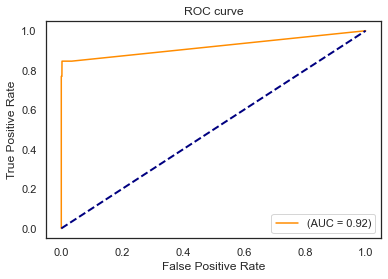

In [56]:
plt.plot(fpr,tpr,color="darkorange",label="(AUC = %0.2f)"%AUC)
plt.plot([0, 1],[0, 1],color="navy",lw=2,linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title('ROC curve')
#plt.show()
plt.savefig(OUTPUTPATH+'RF_ROCcurve_'+BNAB+'_seed'+str(SEEDNUMBER)+'.pdf', bbox_inches='tight')


In [57]:
#Make a big table with predicted and known bnab
# Save TP and FP in txt files to compare them with the 2 other methods
predictions=random_forest.predict(test)
testTable= test.copy()
testTable['is_bnab']= testtarget
testTable['predicted'] = predictions
dataf=testTable[(testTable['predicted'] == 1) & (testTable['is_bnab'] == 0)]
#print(dataf)
dataf.to_csv(OUTPUTPATH+'test_FP_randomForest_'+BNAB+'_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")
dataf=testTable[(testTable['predicted'] == 1) & (testTable['is_bnab'] == 1)]
#print(dataf)
dataf.to_csv(OUTPUTPATH+'test_TP_randomForest_'+BNAB+'_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")
dataf.head()

,HCDR3.length,mut.freq,fwrs.mut.freq,hcdr3.hydrophobicity,LCDR3.length,VH1.lcdr3_5,VH1-69.VK3-20.GW,IGHV1-18,IGHV1-2,IGHV1-24,...,IGLV5-39,IGLV5-45,IGLV5-48,IGLV6-57,IGLV7-43,IGLV7-46,IGLV8-61,IGLV9-49,is_bnab,predicted
15009,15,0.37,0.36,1.70,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
14997,24,0.51,0.51,3.05,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
14989,15,0.34,0.29,2.15,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
14968,12,0.36,0.33,2.20,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
14992,13,0.28,0.26,2.65,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1


In [58]:
print("algo"+"\t"+"BnAb"+"\t"+"seed"+"\t"+"criterion"+"\t"+"RF.max.samples"+"\t"+"RF.max.depth"+"\t"+"TPval"+"\t"+"FPval"+"\t"+"TNval"+"\t"+"FNval"+"\t"+"AUCval"+"\t"+"TPtest"+"\t"+"FPtest"+"\t"+"TNtest"+"\t"+"FNtest"+"\t"+"AUCtest")
print("pruned_tree"+"\t"+BNAB+"\t"+str(SEEDNUMBER)+"\t"+CRITERION+"\t"+str(RFMAXSAMPLES)+"\t"+str(RFMAXDEPTH)+"\t"+str(tp_v_tree)+"\t"+str(fp_v_tree)+"\t"+str(tn_v_tree)+"\t"+str(fn_v_tree)+"\t"+str(AUC_v_tree)+"\t"+str(tp_t_tree)+"\t"+str(fp_t_tree)+"\t"+str(tn_t_tree)+"\t"+str(fn_t_tree)+"\t"+str(AUC_t_tree))
print("random_forest"+"\t"+BNAB+"\t"+str(SEEDNUMBER)+"\t"+CRITERION+"\t"+str(RFMAXSAMPLES)+"\t"+str(RFMAXDEPTH)+"\t"+str(tp_v_RF)+"\t"+str(fp_v_RF)+"\t"+str(tn_v_RF)+"\t"+str(fn_v_RF)+"\t"+str(AUC_v_RF)+"\t"+str(tp_t_RF)+"\t"+str(fp_t_RF)+"\t"+str(tn_t_RF)+"\t"+str(fn_t_RF)+"\t"+str(AUC_t_RF))

algo	BnAb	seed	criterion	RF.max.samples	RF.max.depth	TPval	FPval	TNval	FNval	AUCval	TPtest	FPtest	TNtest	FNtest	AUCtest
pruned_tree	gp120_CD4BS	1	entropy	1.0	None	7	4	2984	8	0.7326639892904954	9	6	2985	4	0.845150837126765
random_forest	gp120_CD4BS	1	entropy	1.0	None	7	0	2988	8	0.8962739848282016	8	0	2991	5	0.9202865005272227


## Now we can test some HIV-1 immune donors

In [59]:
#EXP="G3"

donordata=pd.read_csv(EXPPATH+"AIRR_file_"+EXP+"_featuresTable.tsv",sep='\t')
df1=donordata[["HCDR3.length","mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","LCDR3.length","VH1.lcdr3_5","VH1-69.VK3-20.GW"]]
df2=pd.get_dummies(donordata["vh.gene"])
df3=pd.get_dummies(donordata["vl.gene"])
frames=[df1,df2,df3]
df=pd.concat(frames,axis=1)

df1training=data[["HCDR3.length","mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","LCDR3.length","VH1.lcdr3_5","VH1-69.VK3-20.GW"]]
df2training=pd.get_dummies(data["vh.gene"])
df3training=pd.get_dummies(data["vl.gene"])
framestraining=[df1training,df2training,df3training]
dftraining=pd.concat(framestraining,axis=1)

df.head()

#missing columns from the training dataset
missing=[i for i in training if i not in df.columns]
print("- Missing columns to add:")
print(missing)

for miss in missing:
    df[miss]="0"

#extra column to remove from the donor (some VK)
extra = [i for i in df if i not in training.columns]
print("- Extra columns to remove:")
print(extra)
df = df.drop(columns=extra)

df.head()

#we predict with the random forest algo (the best one)
predictions_donor=random_forest.predict(df) #tree_pruned.predict(df) #random_forest.predict(df)
valTable= df.copy()
valTable['predicted'] = predictions_donor

dataf=valTable[(valTable['predicted'] == 1) ]
dataf=dataf[["HCDR3.length","mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","LCDR3.length","VH1.lcdr3_5","VH1-69.VK3-20.GW"]]
#print(dataf) #to check we have the correct rows
bnab_indexes = dataf.index.to_numpy()
print("- Found indexes:")
print(bnab_indexes)
print("\nNumber of RF potential "+BNAB+" BnAb with experiment "+EXP+": "+str(len(bnab_indexes))+"\n")
bnab_data = donordata.iloc[bnab_indexes]

if not bnab_data.empty:
    print(bnab_data)
    airr_data=pd.read_csv(EXPPATH+"AIRR_file_"+EXP+".tsv",sep='\t')
    bnab_data.rename(columns = {'sequence.id':'sequence_id'}, inplace = True)
    df_to_write= pd.merge(bnab_data,airr_data,on="sequence_id")
    df_to_write.to_csv(EXPPATH+'/'+EXP+'_potential_RF_'+BNAB+'.tsv', sep = "\t",index=False)

- Missing columns to add:
['IGHV3-69-1', 'IGHV4/OR15-8', 'IGKV5-2', 'IGLV3-12']
- Extra columns to remove:
['IGHV1/OR15-1', 'IGLV3-16']
- Found indexes:
[2658 2660]

Number of RF potential gp120_CD4BS BnAb with experiment G4: 2

                   sequence.id  vh.gene  HCDR3.length  hcdr3.hydrophobicity  \
2658  M-4251-G3-K-G4-2302-P4-1  IGHV1-2            12                  2.15   
2660  M-2101-G1-K-G4-2302-P4-1  IGHV1-2            12                  1.80   

       vl.gene  LCDR3.length  mut.freq  fwrs.mut.freq  VH1.lcdr3_5  \
2658  IGKV1-33             5      0.40           0.38            1   
2660  IGKV1-33             5      0.36           0.34            1   

      VH1-69.VK3-20.GW  
2658                 0  
2660                 0  


In [61]:
#we predict with the tree pruned algo 
predictions_donor=tree_pruned.predict(df) #tree_pruned.predict(df) #random_forest.predict(df)
valTable= df.copy()
valTable['predicted'] = predictions_donor

dataf=valTable[(valTable['predicted'] == 1) ]
dataf=dataf[["HCDR3.length","mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","LCDR3.length","VH1.lcdr3_5","VH1-69.VK3-20.GW"]]
#print(dataf) #to check we have the correct rows
bnab_indexes = dataf.index.to_numpy()
print("- Found indexes:")
print(bnab_indexes)
print("\nNumber of tree potential "+BNAB+" BnAb with donor "+EXP+": "+str(len(bnab_indexes))+"\n")
bnab_data = donordata.iloc[bnab_indexes]

if not bnab_data.empty:
    #print(bnab_data)
    airr_data=pd.read_csv(EXPPATH+"AIRR_file_"+EXP+".tsv",sep='\t')
    bnab_data.rename(columns = {'sequence.id':'sequence_id'}, inplace = True)
    df_to_write= pd.merge(bnab_data,airr_data,on="sequence_id")
    df_to_write.to_csv(EXPPATH+'/'+EXP+'_potential_tree_'+BNAB+'.tsv', sep = "\t",index=False)

- Found indexes:
[1926 2248 2339 2398 2435 2658 2659 2660 2666 3682 4663 4760 4770]

Number of tree potential gp120_CD4BS BnAb with donor G4: 13



### Find common BnAbs with other algo

##### Tree vs anomaly detection

In [62]:
df1 = pd.read_csv(EXPPATH+EXP+'_potential_anomalyDetection_'+BNAB+'.tsv', sep = "\t")
df2 = pd.read_csv(EXPPATH+'/'+EXP+'_potential_tree_'+BNAB+'.tsv', sep = "\t")

print("Anomaly")
print(df1.shape)

common = pd.merge(df1, df2, how='inner', on=['sequence_id'])
print("Common Abs found in the 2 methods tree and anomaly detection are : ")
if not common.empty :
    print("    -> !! YES WE HAVE common Ab!!\n")
    print(common['sequence_id'])
else:
    print("     ->  no common Ab")


Anomaly
(47, 110)
Common Abs found in the 2 methods tree and anomaly detection are : 
    -> !! YES WE HAVE common Ab!!

0    M-4251-G3-K-G4-2302-P4-1
1    M-2101-G1-K-G4-2302-P4-1
Name: sequence_id, dtype: object


#### RF vs anomaly detection

In [63]:

df1 = pd.read_csv(EXPPATH+'/'+EXP+'_potential_RF_'+BNAB+'.tsv', sep = "\t")
df2 = pd.read_csv(EXPPATH+EXP+'_potential_anomalyDetection_'+BNAB+'.tsv', sep = "\t")

common = pd.merge(df1, df2, how='inner', on=['sequence_id'])
print("Common Abs found in the 2 methods RF and anomaly detection are : ")

if not common.empty :
    print("    -> !! YES WE HAVE common Ab!!\n")
    print(common['sequence_id'])
else:
    print("     ->  no common Ab")


Common Abs found in the 2 methods RF and anomaly detection are : 
    -> !! YES WE HAVE common Ab!!

0    M-4251-G3-K-G4-2302-P4-1
1    M-2101-G1-K-G4-2302-P4-1
Name: sequence_id, dtype: object


#### RF vs tree

In [64]:
df1 = pd.read_csv(EXPPATH+'/'+EXP+'_potential_RF_'+BNAB+'.tsv', sep = "\t")
df2 = pd.read_csv(EXPPATH+'/'+EXP+'_potential_tree_'+BNAB+'.tsv', sep = "\t")

common = pd.merge(df1, df2, how='inner', on=['sequence_id'])
print("Common Abs found in the 2 methods RF and tree are : ")
if not common.empty :
    print("    -> !! YES WE HAVE common Ab!!\n")
    print(common['sequence_id'])
else:
    print("     ->  no common Ab")

Common Abs found in the 2 methods RF and tree are : 
    -> !! YES WE HAVE common Ab!!

0    M-4251-G3-K-G4-2302-P4-1
1    M-2101-G1-K-G4-2302-P4-1
Name: sequence_id, dtype: object
